<a href="https://colab.research.google.com/github/KORALLLL/summer_practice/blob/main/bagging/additional_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Дополнительное исследование на размер батча в связи с изменением параметра обучающего датасета

датасет: MNIST

размер обучающей выборки: 6000(сырого) + 14000(аугментаций)

размер тестирующей выборки: 10000

количество скрытых слоёв: 2

количество нейронов в скрытых слоя: 200

функция активации: сигмоида

функция потерь: кросс энтропия

оптимизатор: RMSprop

скорость обучение: 0.001

размер батча: 100, 200, 400, 500, 800, 1000, 2000, 4000

количество эпох: 100

In [2]:
start = 0
stop = 6000

import torch
import torchvision.datasets
import torchvision.transforms
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as bar
from PIL import Image

def augmentation(old_image, label):
  old_image = Image.fromarray(old_image.numpy(), mode='L')

  rotater = torchvision.transforms.RandomRotation(degrees = (-15, 15))
  h_flipper = torchvision.transforms.RandomHorizontalFlip(p=1) #only for 08
  v_flipper = torchvision.transforms.RandomVerticalFlip(p=1) #only for 08
  shifter = torchvision.transforms.RandomAffine(0, translate = (2/28,2/28))
  compressor = torchvision.transforms.RandomAffine(0, scale = (0.8, 0.9))
  stratcher = torchvision.transforms.RandomAffine(0, scale = (1.05, 1.1))

  seed1 = random.randint(0, 3)
  if label == 0 or label == 8:
    if seed1 == 0:
      image = old_image
    elif seed1 == 1:
      image = h_flipper(old_image)
    elif seed1 == 2:
      image = v_flipper(old_image)
    else:
      image = h_flipper(v_flipper(old_image))
  else:
    image = old_image

  seed = random.randint(0,10)
  if seed == 0: #rot
    new_image = rotater(image)
  elif seed == 1: #shift
    new_image = shifter(image)
  elif seed == 2: #comp
    new_image = compressor(image)
  elif seed == 3: #str
    new_image = stratcher(image)
  elif seed == 4: #rot+shift
    new_image = rotater(shifter(image))
  elif seed == 5: #rot+comp
    new_image = rotater(compressor(image))
  elif seed == 6: #rot+str
    new_image = rotater(stratcher(image))
  elif seed == 7: #shift+comp
    new_image = shifter(compressor(image))
  elif seed == 8: #shift+stretch
    new_image = shifter(stratcher(image))
  elif seed == 9: #rot+shift+comp
    new_image = rotater(shifter(compressor(image)))
  elif seed == 10: #tor+shift+stretch
    new_image = rotater(shifter(stratcher(image)))

  new_image = torchvision.transforms.ToTensor()(new_image)
  new_image = new_image.squeeze()
  return(new_image)


mnist_train = torchvision.datasets.MNIST('./', download = True, train = True)
mnist_test = torchvision.datasets.MNIST('./', download = True, train = False)

train_data = mnist_train.data[start:stop]
train_labels = mnist_train.targets[start:stop]

temp_train_data, temp_train_label = [], []
random_indexes = random.choices(range(0,6000), k=14000)

for i in random_indexes:
  image, label = train_data[i], train_labels[i]
  new_image = augmentation(image, label)
  temp_train_data.append(new_image)
  temp_train_label.append(label)

temp_train_data = torch.stack(temp_train_data)
temp_train_label = torch.stack(temp_train_label)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data = torch.cat([train_data, temp_train_data], dim = 0).float().reshape([-1,28*28]).to(device)
train_labels = torch.cat([train_labels, temp_train_label], dim = 0).to(device)
test_data = mnist_test.data.float().reshape([-1, 28*28]).to(device)
test_labels = mnist_test.targets.to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 214384039.91it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26067504.59it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 66625801.01it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2961835.94it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [13]:
class MNISTNet(torch.nn.Module):
  def __init__(self):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28*28, 200)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(200, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    return x

loss = torch.nn.CrossEntropyLoss()
batch_size = [100, 200, 400, 500, 800, 1000, 2000, 4000]

batch_res_accuracy = [[] for batchsize in range(len(batch_size))]

In [14]:
for batchsize in bar(range(len(batch_size)), desc = 'explorations'):
  for experiment in bar(range(20), desc = 'experimenting'):

    net = MNISTNet().to(device)

    optimizer = torch.optim.RMSprop(net.parameters(), lr= 0.001)

    for epoch in bar(range(500), desc = 'learning'):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size[batchsize]):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size[batchsize]]

        train_data_batch = train_data[batch_indexes]
        train_labels_batch = train_labels[batch_indexes]

        preds = net.forward(train_data_batch)

        loss_val = loss(preds, train_labels_batch)
        loss_val.backward()

        optimizer.step()

    test_preds = net.forward(test_data)

    batch_res_accuracy[batchsize].append((test_preds.argmax(dim=1) == test_labels).float().mean().cpu().data)


<ipython-input-14-fb8430140882>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batchsize in bar(range(len(batch_size)), desc = 'explorations'):


explorations:   0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-14-fb8430140882>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(20), desc = 'experimenting'):


experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-14-fb8430140882>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(500), desc = 'learning'):


learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-14-fb8430140882>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(500), desc = 'learning'):


learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-14-fb8430140882>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(20), desc = 'experimenting'):


experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

experimenting:   0%|          | 0/20 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

learning:   0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
batch_res_accuracy[0]

[tensor(0.7620),
 tensor(0.7654),
 tensor(0.7603),
 tensor(0.7619),
 tensor(0.7507),
 tensor(0.7549),
 tensor(0.7622),
 tensor(0.7639),
 tensor(0.7569),
 tensor(0.7551)]

Text(0.5, 1.0, 'Зависимость точности модели от размера батча')

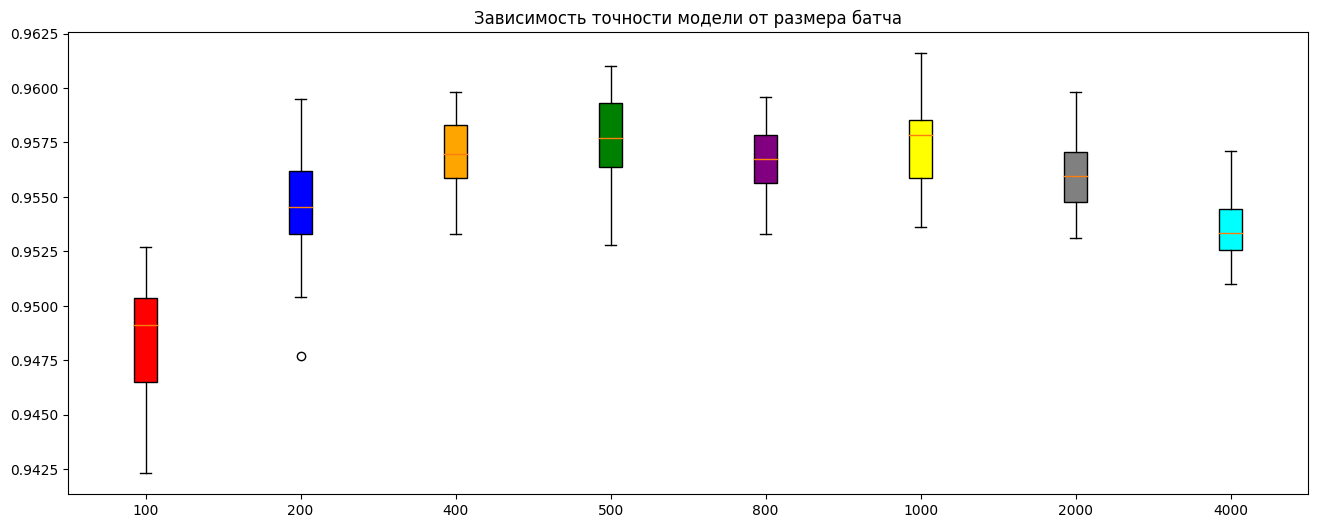

In [22]:
plt.figure(figsize = (16.0, 6.0))

batch_size = [100, 200, 400, 500, 800, 1000, 2000, 4000]

colors = ['red', 'blue', 'orange', 'green', 'purple', 'yellow', 'grey', 'cyan']

indexes = [i for i in range(8)]

for batch in indexes:
  y = plt.boxplot(batch_res_accuracy[batch], positions = [batch], patch_artist = True)
  y['boxes'][0].set_facecolor(colors[batch])

plt.xticks(range(8), [str(i) for i in batch_size])
plt.title("Зависимость точности модели от размера батча")

Text(0.5, 1.0, 'Зависимость точности модели от размера батча')

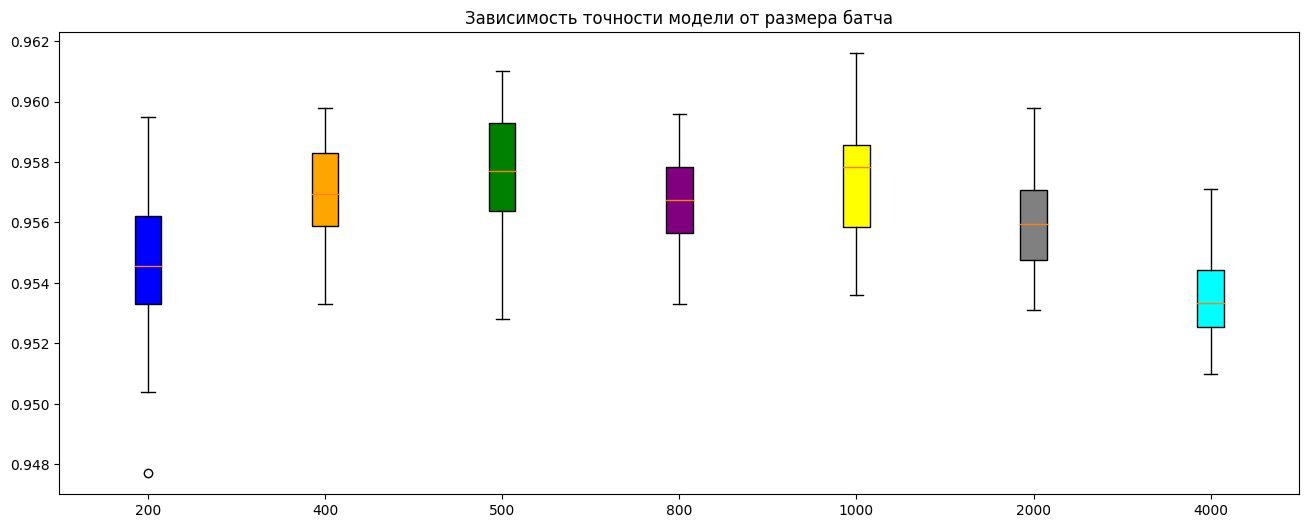

In [27]:
plt.figure(figsize = (16.0, 6.0))

batch_size = [200, 400, 500, 800, 1000, 2000, 4000]

colors = ['blue', 'orange', 'green', 'purple', 'yellow', 'grey', 'cyan']

indexes = [i for i in range(7)]

for batch in indexes:
  y = plt.boxplot(batch_res_accuracy[batch+1], positions = [batch], patch_artist = True)
  y['boxes'][0].set_facecolor(colors[batch])

plt.xticks(range(7), [str(i) for i in batch_size[:]])
plt.title("Зависимость точности модели от размера батча")